In [34]:
import sympy
from sympy import Matrix, Rational, sqrt, symbols, zeros, simplify, exp
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import matplotlib.pyplot as plt
import sklearn
from sklearn.datasets import load_iris
import pandas as pd

import seaborn as sns

%matplotlib inline


# Mathematics for Machine Learning

## Session 13: Principal Component Analysis

### Gerhard Jäger


December 3, 2024



In [35]:
iris = load_iris()
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df['species'] = pd.Categorical.from_codes(iris.target, iris.target_names)
X = iris_df.values[:,:-1].astype(float)

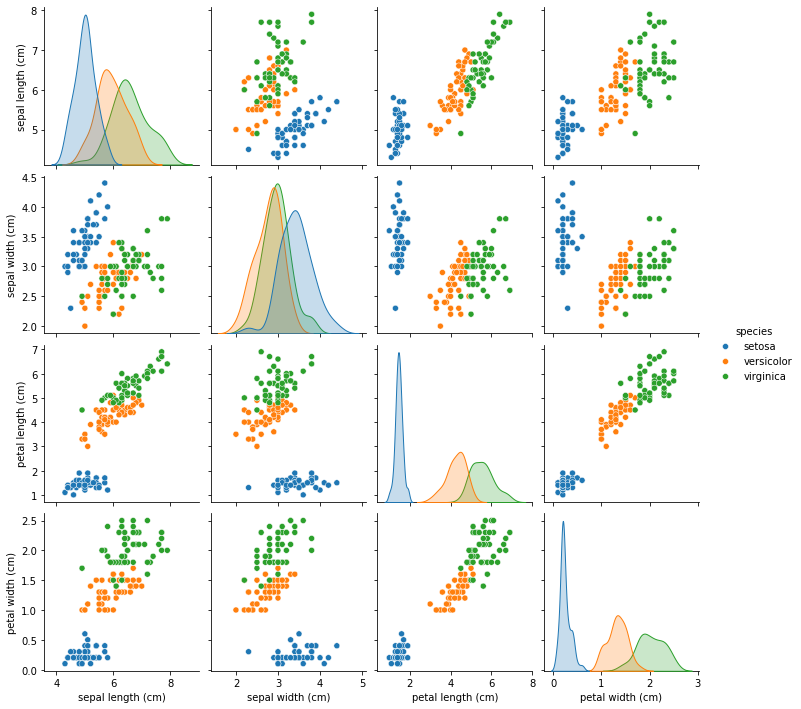

In [36]:
sns.pairplot(iris_df,hue='species')

# Techniques of Dimensionality Reduction

## Principal Component Analysis (PCA)

- PCA is a linear transformation technique used to identify strong patterns in data.
- It transforms the data into a new coordinate system, reducing the number of dimensions without significant loss of information.

## t-Distributed Stochastic Neighbor Embedding (t-SNE)

- t-SNE is a non-linear technique particularly well-suited for the visualization of high-dimensional datasets.
- It reduces dimensionality while keeping similar instances close and dissimilar instances apart.

## Others

- Linear Discriminant Analysis (LDA)
- Autoencoders (for deep learning approaches)
- Feature selection methods (e.g., backward elimination, forward selection).


# Considerations in Dimensionality Reduction

## Choosing the Right Technique

- The choice of technique depends on the nature of the data and the specific requirements of the task.
- PCA is often preferred for linear data, while t-SNE is chosen for complex, non-linear data patterns.

## Data Preprocessing

- Normalizing or standardizing data is crucial before applying dimensionality reduction techniques.
- It ensures that features with larger scales do not dominate the results.

## Interpretability

- While dimensionality reduction can simplify data, it can also make the results harder to interpret.
- It's important to balance between reducing dimensions and maintaining interpretability for meaningful insights.


Suppose we have an $m$-dimensional unit vector $\mathbf v$ ($m$ being the number of columns of $X$), and we project all rows in $X$ onto $\mathbf v$.

This give us a matrix $X_v$ where all rows are multiples of $\mathbf v$.


$$
\begin{aligned}
X_v &= X \mathbf v(\mathbf v^T\mathbf v)^{-1}\mathbf v'\\
&= X\mathbf v\mathbf v'
\end{aligned}
$$

Let us check whether $X_v$ is centered.

$$
\begin{aligned}
\mathbf 1' X_v &= \mathbf 1' X\mathbf v \mathbf v'\\
&= \mathbf 0'\mathbf v \mathbf v'\\
&=\mathbf 0'
\end{aligned}
$$

Let us calculate the total variance of $X_v$.

$$
\begin{aligned}
\text{var}(X_v) &= \frac{1}{n}\sum_i(X_v'X_v)_{i,i}\\
&= \frac{1}{n}\sum_i\sum_j((x_v)_{j,i})^2\\
&= \frac{1}{n}\sum_{i,j}((X\mathbf v\mathbf v')_{j,i})^2\\
&= \frac{1}{n}\sum_{i,j}((X\mathbf v)_{j} v_{i})^2\\
&= \frac{1}{n}\sum_iv_i^2\sum_j((X\mathbf v)_{j})^2\\
&=\frac{1}{n}\|\mathbf v\|^2 \|X\mathbf v\|^2\\
&=\frac{1}{n}\|X\mathbf v\|^2
\end{aligned}
$$


We want to find the unit vector $\mathbf v$ that maximizes the total variance of $X_v$.

Since $X'X$ is symmetric and positive semi-definite, there is an orthogonal matrix $Q$ and a non-negative diagonal matrix $\Lambda$ with

$$
X'X = Q\Lambda Q'
$$

We assume that the diagonal entries of $\Lambda$ are ordered in descending order.

So we have

$$
\begin{aligned}
\arg\max_{\mathbf v} \text{var}(X_v) &= \arg\max_{\mathbf v} \frac{1}{n}\|X\mathbf v\|^2\\
&=\arg\max_{\mathbf v} \|X\mathbf v\|^2\\
&=\arg\max_{\mathbf v} \mathbf v' X'X\mathbf v\\
&=\arg\max_{\mathbf v} \mathbf v' Q\Lambda Q'\mathbf v\\
\end{aligned}
$$



Let us define $\mathbf w = Q'\mathbf v$. Since $Q$ is orthogonal, we also have $\mathbf v=Q\mathbf w$.

$$
\begin{aligned}
\max_{\mathbf v} \text{var}(X_v) &= \max_{\mathbf w}\mathbf w'\Lambda \mathbf w\\
&= \max_{\mathbf w}\sum_i \lambda_i w_i^2
\end{aligned}
$$

$\mathbf w$ is a unit vector, i.e., $\sum_iw_i^2 = 1$. Also, $\forall i, w_i^2\leq 1$. Therefore, the vector $\mathbf w$ maximizing $\sum_i \lambda_i w_i^2$ is the vector with 1 in the first cell and 0 everywhere else.

$$
\mathbf w^* = \begin{pmatrix}1 \\ 0 \\ \vdots \\ 0\end{pmatrix}
$$

It follows that 

$$
\mathbf v^* = \mathbf q_1
$$

The data in $X$ have most variance along the eigenvector of $X'X$ corresponding to the largest eigenvalue. 


In [37]:
q1 = np.linalg.eig(X.T @ X)[1][:,0]
q1

array([0.75110816, 0.38008617, 0.51300886, 0.16790754])

In [38]:
Xv = X @ q1.reshape(-1,1) @ q1.reshape(1, -1)
pd.DataFrame(Xv)

0         1         2         3
0    4.441113  2.247353  3.033292  0.992795
1    4.185537  2.118024  2.858733  0.935662
2    4.091269  2.070321  2.794348  0.914589
3    4.083369  2.066323  2.788952  0.912823
4    4.413245  2.233251  3.014258  0.986565
..        ...       ...       ...       ...
145  6.930112  3.506871  4.733285  1.549202
146  6.434192  3.255919  4.394570  1.438341
147  6.779444  3.430628  4.630378  1.515520
148  6.839290  3.460912  4.671253  1.528899
149  6.377190  3.227074  4.355638  1.425598

[150 rows x 4 columns]

total variance of the full data

In [41]:
(X.T @ X).trace() / X.shape[0]

63.59526666666666

variance along the first eigenvector

In [42]:
(Xv.T @ Xv).trace() / X.shape[0]

61.38870046876565

data after orthogonal projection onto the first eigenspace

In [6]:
X1_df = pd.DataFrame(Xv)
X1_df["species"] = iris_df["species"]
X1_df.columns = iris_df.columns
X1_df

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0             4.441113          2.247353           3.033292          0.992795   
1             4.185537          2.118024           2.858733          0.935662   
2             4.091269          2.070321           2.794348          0.914589   
3             4.083369          2.066323           2.788952          0.912823   
4             4.413245          2.233251           3.014258          0.986565   
..                 ...               ...                ...               ...   
145           6.930112          3.506871           4.733285          1.549202   
146           6.434192          3.255919           4.394570          1.438341   
147           6.779444          3.430628           4.630378          1.515520   
148           6.839290          3.460912           4.671253          1.528899   
149           6.377190          3.227074           4.355638          1.425598   

       species  
0       setosa  
1       setosa  
2       setosa  
3       setosa  
4       setosa  
..         ...  
145  virginica  
146  virginica  
147  virginica  
148  virginica  
149  virginica  

[150 rows x 5 columns]

original data

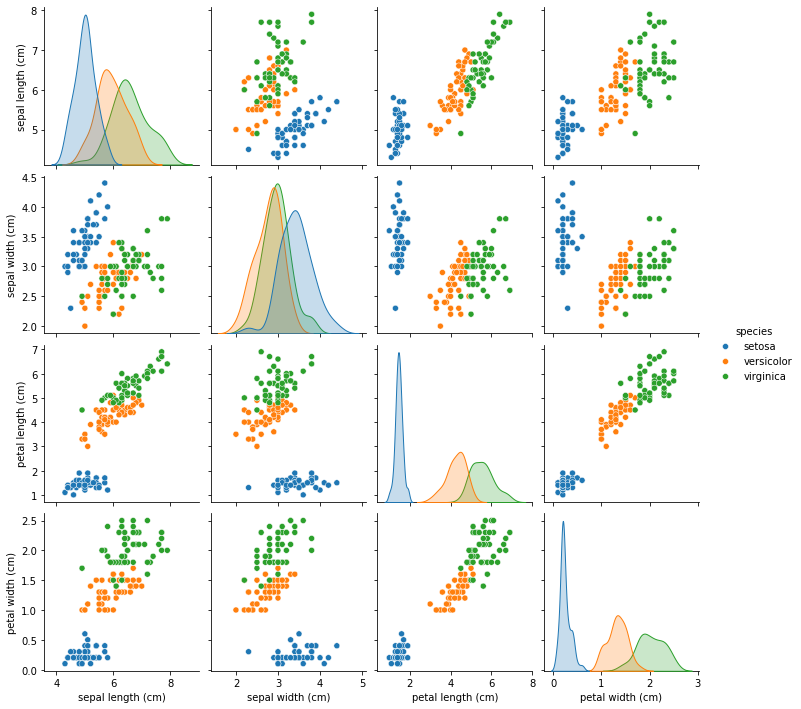

In [7]:
sns.pairplot(iris_df,hue='species')


projected data

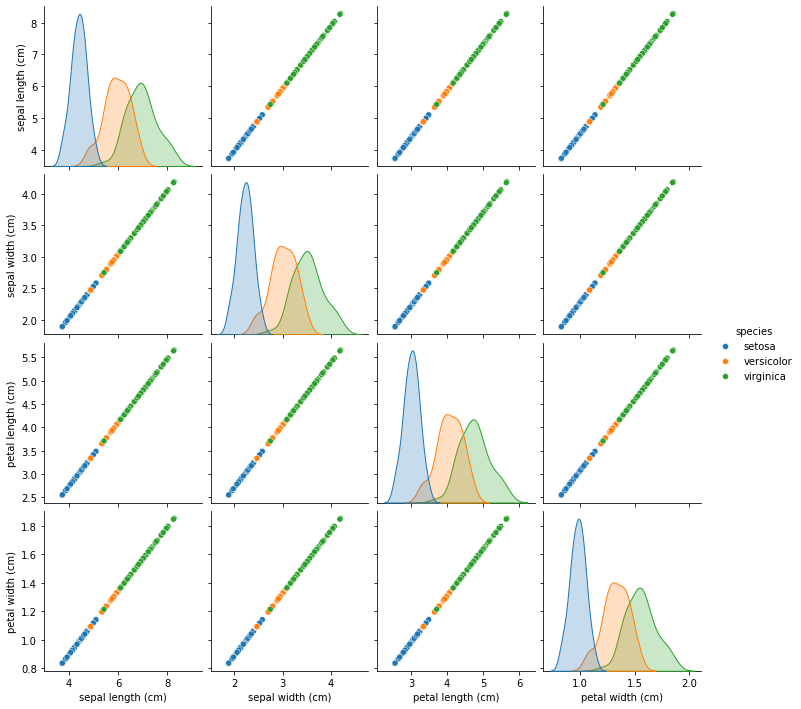

In [8]:
sns.pairplot(X1_df,hue='species')

We can also choose $Q$ as new basis of the coordinate system.

In [9]:
Q = np.linalg.eig(X.T @ X)[1]


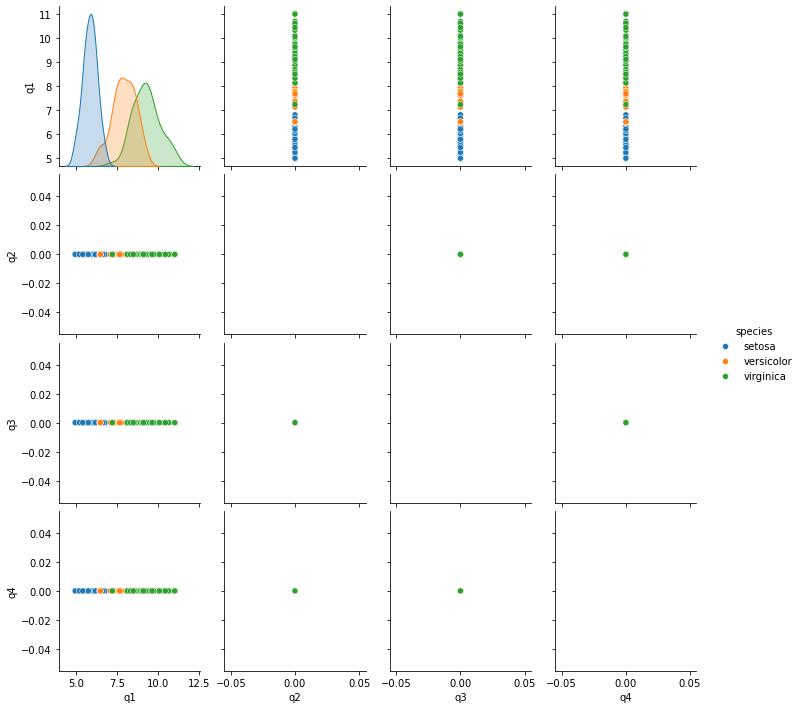

In [10]:
X1_rotated = Xv @ Q
X1_rotated_df = pd.DataFrame(X1_rotated)
X1_rotated_df
X1_rotated_df.columns = ["q1", "q2", "q3", "q4"]
X1_rotated_df["species"] = iris_df["species"]
sns.pairplot(X1_rotated_df.round(2),hue='species')

<AxesSubplot:xlabel='species', ylabel='q1'>

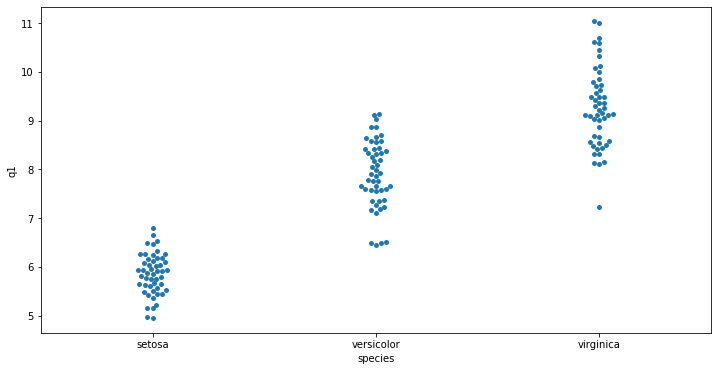

In [11]:
plt.figure(figsize=(12, 6))
sns.swarmplot(x="species", y="q1", data=X1_rotated_df)

The remaining information in the original data is represented by the projection of $X$ onto the orthogonal complement of $\mathbf q_1$.

$$
X_{-1} = X - X\mathbf q_1\mathbf q_1'
$$

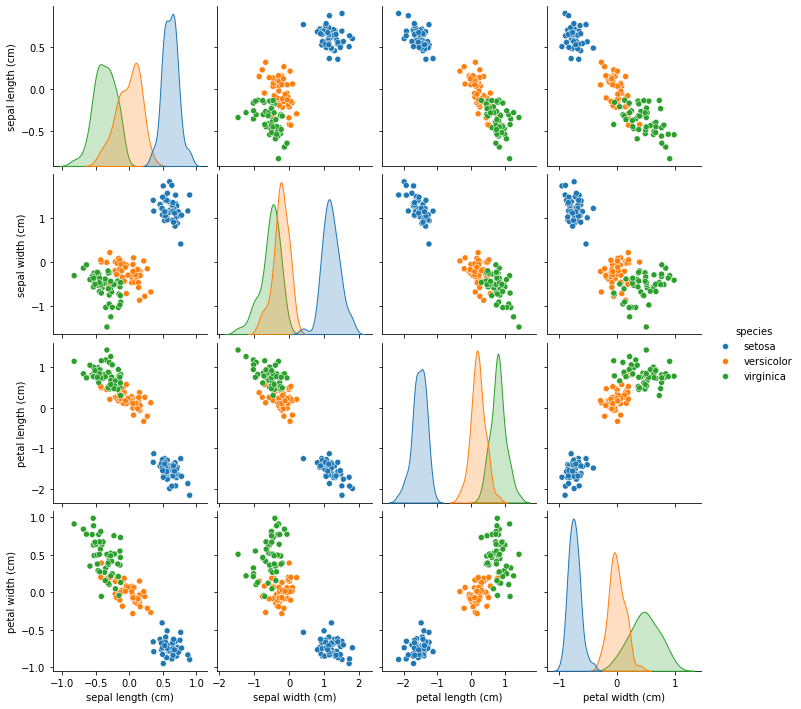

In [12]:
X_without1 = X - Xv
X_without1_df = pd.DataFrame(X_without1)
X_without1_df["species"] = iris_df["species"]
X_without1_df.columns = iris_df.columns
sns.pairplot(X_without1_df,hue='species')

$X_{-1}'X_{-1}$ has the same eigenvectors as $X'X$:

- $\mathbf q_1$ is an eigenvector with eigenvalue 0

$$
\begin{aligned}
X_{-1}'X_{-1}\mathbf q_1 &= (X-Xv)'(X-X_v)\mathbf q_1\\
&=(X-X\mathbf q_1\mathbf q_1')'(X-X\mathbf q_1\mathbf q_1')\mathbf q_1\\
&=(X'-\mathbf q_1\mathbf q_1'X')(X-X\mathbf q_1\mathbf q_1')\mathbf q_1\\
&=(X'X - X'X\mathbf q_1\mathbf q_1' - \mathbf q_1\mathbf q_1'X'X + \mathbf q_1\mathbf q_1'X'X\mathbf q_1\mathbf q_1')\mathbf q_1\\
&= (Q\Lambda Q' - Q\Lambda Q'\mathbf q_1\mathbf q_1' - \mathbf q_1\mathbf q_1'Q\lambda Q' + \mathbf q_1\mathbf q_1'Q\Lambda Q'\mathbf q_1\mathbf q_1')\mathbf q_1\\
&= Q\Lambda Q'\mathbf q_1 - Q\Lambda Q'\mathbf q_1\mathbf q_1'\mathbf q_1 - \mathbf q_1\mathbf q_1'Q\Lambda Q'\mathbf q_1 + \mathbf q_1\mathbf q_1'Q\Lambda Q'\mathbf q_1\mathbf q_1'\mathbf q_1\\
&= Q\Lambda Q'\mathbf q_1 - Q\Lambda Q'\mathbf q_1 - \mathbf q_1\mathbf q_1'Q\Lambda Q'\mathbf q_1 + \mathbf q_1\mathbf q_1'Q\Lambda Q'\mathbf q_1\\
&= \mathbf 0
\end{aligned}
$$



- $\mathbf q_i$ for $i\neq 1$ has eigenvalue $\lambda_i$

$$
\begin{aligned}
X_{-1}'X_{-1}\mathbf q_i &= (X-Xv)'(X-X_v)\mathbf q_i\\
&=(X-X\mathbf q_1\mathbf q_1')'(X-X\mathbf q_1\mathbf q_1')\mathbf q_i\\
&=(X'-\mathbf q_1\mathbf q_1'X')(X-X\mathbf q_1\mathbf q_1')\mathbf q_i\\
&=(X'X - X'X\mathbf q_1\mathbf q_1' - \mathbf q_1\mathbf q_1'X'X + \mathbf q_1\mathbf q_1'X'X\mathbf q_1\mathbf q_1')\mathbf q_i\\
&= (Q\Lambda Q' - Q\Lambda Q'\mathbf q_1\mathbf q_1' - \mathbf q_1\mathbf q_1'Q\lambda Q' + \mathbf q_1\mathbf q_1'Q\Lambda Q'\mathbf q_1\mathbf q_1')\mathbf q_i\\
&= Q\Lambda Q'\mathbf q_i - Q\Lambda Q'\mathbf q_1\mathbf q_1'\mathbf q_i - \mathbf q_1\mathbf q_1'Q\Lambda Q'\mathbf q_i + \mathbf q_1\mathbf q_1'Q\Lambda Q'\mathbf q_1\mathbf q_1'\mathbf q_i\\
&= Q\Lambda \mathbf e_i  - \mathbf q_1\mathbf e_1'\Lambda \mathbf e_i \\
&= \lambda_i \mathbf q_i \\
\end{aligned}
$$

The largest eigenvalue of $X_{-1}$ is $\lambda_2$, so $\mathbf q_2$ is the direction along which $X_{-1}$ has most variance.

In other words, the sub-space with the base $\mathbf q_1, \mathbf q_2$ is the two-dimensional space preserving most variance in $X$ among all two-dimensional spaces.

The projection of $X$ onto this sub-space is

$$
X_2 = X Q \begin{pmatrix}
1 & 0 & 0 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & 0 & 0\\
0 & 0 & 0 & 0
\end{pmatrix}
$$

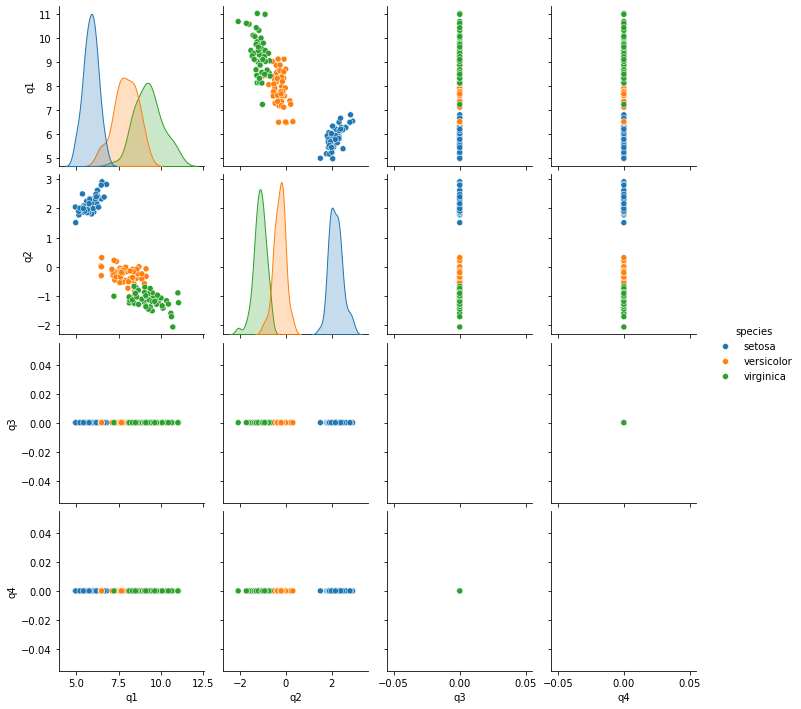

In [13]:
X2 = X @ Q @ np.diag([1, 1, 0, 0])
X2
X2_df = pd.DataFrame(X2)
X2_df.columns = ["q1", "q2", "q3", "q4"]
X2_df["species"] = iris_df["species"]
sns.pairplot(X2_df,hue='species')

In [14]:
X_rotated = X @ Q
X_rotated_df = pd.DataFrame(X_rotated)
X_rotated_df.columns = ["q1", "q2", "q3", "q4"]
X_rotated_df["species"] = iris_df["species"]

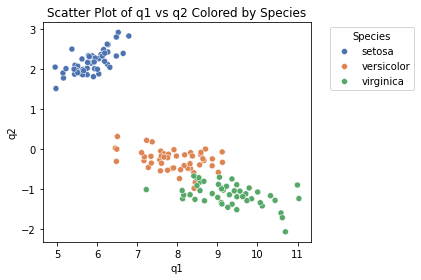

In [15]:
sns.scatterplot(x="q1", y="q2", hue="species", data=X_rotated_df, palette="deep")
plt.title('Scatter Plot of q1 vs q2 Colored by Species')
plt.xlabel('q1')
plt.ylabel('q2')

# Place the legend outside the plot
plt.legend(title='Species', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust the margins and layout
plt.tight_layout()

# Show the plot
plt.show()

comparing to the original data (after rotation)

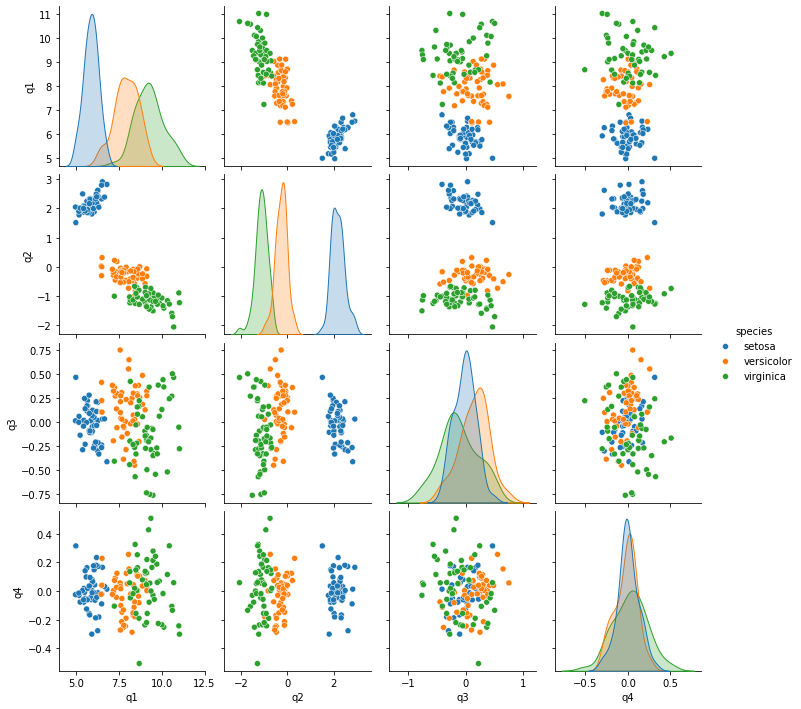

In [16]:
sns.pairplot(X_rotated_df,hue='species')

in 3d

In [17]:
import plotly.express as px

df = X_rotated_df
fig = px.scatter_3d(df, x='q1', y='q2', z='q3', color='species')

# Update plot layout
fig.update_layout(
    title='3D Scatter Plot of Q1, Q2, Q3 by Species',
    scene=dict(
        xaxis_title='Q1',
        yaxis_title='Q2',
        zaxis_title='Q3'
    )
)

# Show the plot
fig.show()


## Principal component analyis

- useful for visualization – projection onto the space of the first 2 or 3 eigenvectors can be plotted 
- also useful to separate signal from noise
- often, signal dominates the first $k$ dimensions, while the rest mostly contains noise.
- $k$ can be determined by eyeballing the magnitude of the eigenvalues

<BarContainer object of 4 artists>

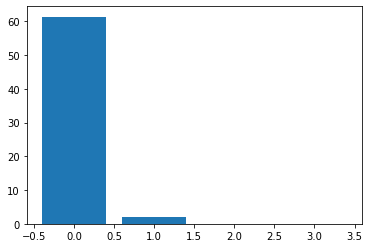

In [18]:
plt.bar(range(4),np.linalg.eig(X.T @ X)[0]/X.shape[0])


## Another example: hand-written digits


In [19]:
from sklearn.datasets import load_digits
digits = load_digits()
print(digits)

{'data': array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]]), 'target': array([0, 1, 2, ..., 8, 9, 8]), 'frame': None, 'feature_names': ['pixel_0_0', 'pixel_0_1', 'pixel_0_2', 'pixel_0_3', 'pixel_0_4', 'pixel_0_5', 'pixel_0_6', 'pixel_0_7', 'pixel_1_0', 'pixel_1_1', 'pixel_1_2', 'pixel_1_3', 'pixel_1_4', 'pixel_1_5', 'pixel_1_6', 'pixel_1_7', 'pixel_2_0', 'pixel_2_1', 'pixel_2_2', 'pixel_2_3', 'pixel_2_4', 'pixel_2_5', 'pixel_2_6', 'pixel_2_7', 'pixel_3_0', 'pixel_3_1', 'pixel_3_2', 'pixel_3_3', 'pixel_3_4', 'pixel_3_5', 'pixel_3_6', 'pixel_3_7', 'pixel_4_0', 'pixel_4_1', 'pixel_4_2', 'pixel_4_3', 'pixel_4_4', 'pixel_4_5', 'pixel_4_6', 'pixel_4_7', 'pixel_5_0', 'pixel_5_1', 'pixel_5_2', 'pixel_5_3', 'pixel_5_4', 'pixel_5_5', 'pixel_5_6', 'pixel_5_7', 'pixel_6_0', '

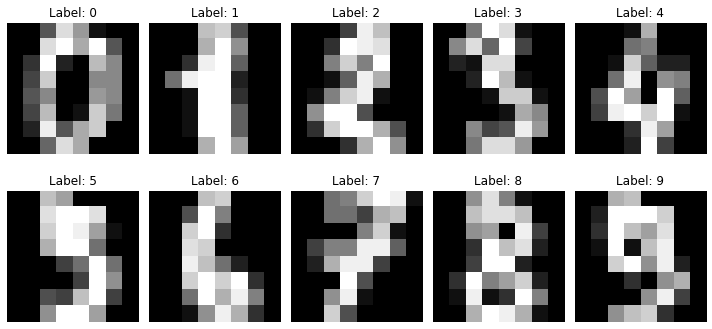

In [20]:

# Set up the figure for a grid of images
fig, axes = plt.subplots(2, 5, figsize=(10, 5))  # 2 rows, 5 columns
for ax, image, label in zip(axes.ravel(), digits.images, digits.target):
    ax.imshow(image, cmap='gray')
    ax.set_title(f"Label: {label}")
    ax.axis('off')  # Hide axes

plt.tight_layout()
plt.show()


In [21]:
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(digits.data)
print(X)

[[ 0.         -0.33501649 -0.04308102 ... -1.14664746 -0.5056698
  -0.19600752]
 [ 0.         -0.33501649 -1.09493684 ...  0.54856067 -0.5056698
  -0.19600752]
 [ 0.         -0.33501649 -1.09493684 ...  1.56568555  1.6951369
  -0.19600752]
 ...
 [ 0.         -0.33501649 -0.88456568 ... -0.12952258 -0.5056698
  -0.19600752]
 [ 0.         -0.33501649 -0.67419451 ...  0.8876023  -0.5056698
  -0.19600752]
 [ 0.         -0.33501649  1.00877481 ...  0.8876023  -0.26113572
  -0.19600752]]


In [22]:
from sklearn.decomposition import PCA

# Choosing the number of components for example 2 for easy visualization
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)


In [23]:

principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])


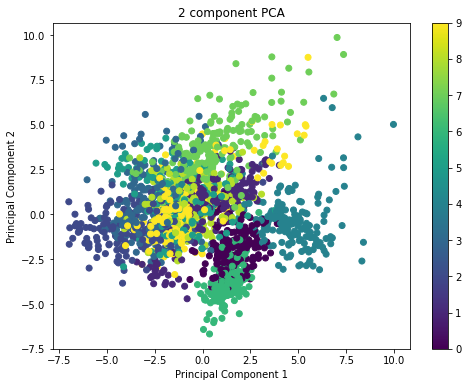

In [24]:
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False  # Disable grids for all axes
import matplotlib.pyplot as plt

# Create the figure
plt.figure(figsize=(8, 6))

# Scatter plot
plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'], 
            c=digits.target, cmap='viridis')

# Labels and title
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2 component PCA')

# Add colorbar and explicitly turn off the grid globally
cb = plt.colorbar()
cb.ax.grid(False)  # Disable grid on the colorbar explicitly

# Explicitly disable gridlines for pcolormesh in case it's called internally
plt.grid(False)

# Show plot
plt.show()


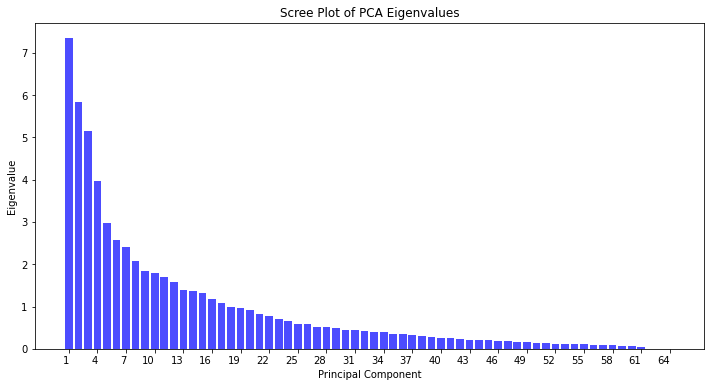

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X)
eigenvalues = pca.explained_variance_

plt.figure(figsize=(12, 6))
plt.bar(range(1, len(eigenvalues) + 1), eigenvalues, alpha=0.7, color='blue')
plt.ylabel('Eigenvalue')
plt.xlabel('Principal Component')
plt.title('Scree Plot of PCA Eigenvalues')

# Label every third PC
x_ticks = np.arange(1, len(eigenvalues) + 1, 3)  # Every third PC
plt.xticks(x_ticks, rotation=0, ha='right')

plt.show()


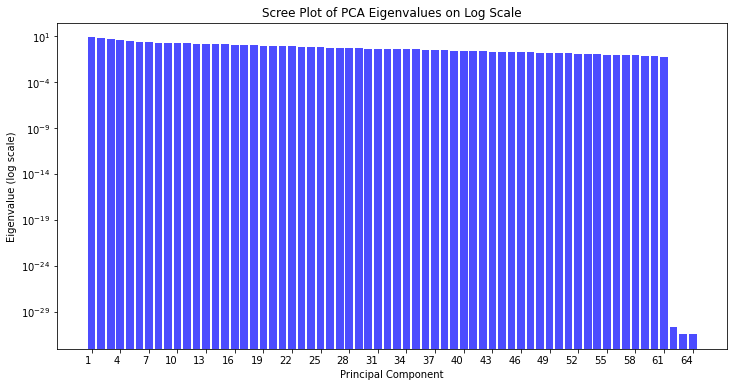

In [26]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
import numpy as np

# Load and standardize the digits dataset
digits = load_digits()
X = StandardScaler().fit_transform(digits.data)

# Perform PCA
pca = PCA()
pca.fit(X)
eigenvalues = pca.explained_variance_

# Create a bar plot with a log-transformed y-scale
plt.figure(figsize=(12, 6))
plt.bar(range(1, len(eigenvalues) + 1), eigenvalues, alpha=0.7, color='blue')
plt.yscale('log')  # Log transform the y-axis
plt.ylabel('Eigenvalue (log scale)')
plt.xlabel('Principal Component')
plt.title('Scree Plot of PCA Eigenvalues on Log Scale')

# Label every third PC
x_ticks = np.arange(1, len(eigenvalues) + 1, 3)  # Every third PC
plt.xticks(x_ticks, rotation=0, ha='right')

plt.show()


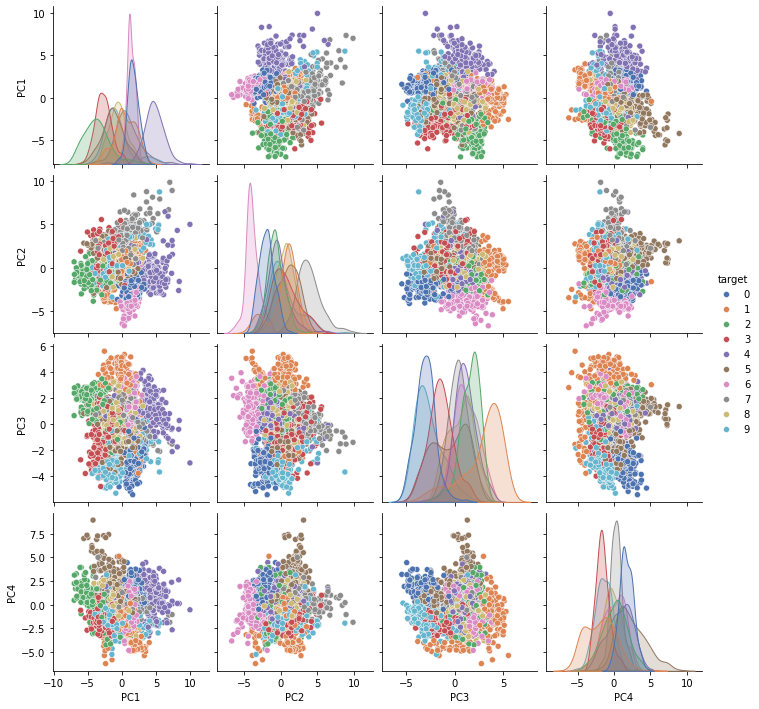

In [27]:
# Perform PCA
pca = PCA(n_components=4)
principalComponents = pca.fit_transform(X)

# Create a DataFrame with the principal components
principalDf = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2', 'PC3', 'PC4'])

# Add the target variable
principalDf['target'] = digits.target

# Create the pairplot
palette = sns.color_palette("deep", 10) # '10' for the number of unique digits

sns.pairplot(principalDf, hue="target", palette=palette)

# Show the plot
plt.show()